In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygame
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import copy

from tqdm import tqdm
import time

pygame-ce 2.4.0 (SDL 2.28.5, Python 3.11.9)


### Brain (Policy)

In [2]:
class Brain(nn.Module):
    def __init__(self, num_layers=3, device='cuda', input_size=3, output_size=4, hidden_dim=6):
        super(Brain, self).__init__()
        self.device = torch.device(device)
        self.loss_history = []
        self.num_layers = num_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_dim).to(device))  # Input layer
        for _ in range(num_layers - 2):  # Hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim).to(device))
        self.layers.append(nn.Linear(hidden_dim, output_size).to(device))  # Output layer

    def forward(self, x):
        x = x.to(self.device)
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = torch.nn.functional.softmax(self.layers[-1](x), dim=0)  # No activation on the output layer
        return x  
    
    def track_forward(self, x):
        x_track = []
        w_track = []

        x = x.to(self.device)
        x_track.append(x.cpu().detach().numpy())

        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
            x_track.append(x.cpu().detach().numpy())
            w_track.append(layer.weight.cpu().detach().numpy())

        x = torch.nn.functional.softmax(self.layers[-1](x), dim=0)  # No activation on the output layer
        x_track.append(x.cpu().detach().numpy())
        w_track.append(self.layers[-1].weight.cpu().detach().numpy())

        return x_track, w_track
    
    def get_dna(self):
        w_track = []
        for layer in self.layers:
            w_track.append(layer.weight.cpu().detach().numpy().flatten())
        floats = np.concatenate(w_track)

        # Normalize the floats to the range 0-1
        min_val = min(floats)
        max_val = max(floats)
        normalized_floats = [(f - min_val) / (max_val - min_val) for f in floats]
        
        # Map the normalized floats to ASCII values in the range 97-122 (lowercase letters)
        ascii_vals = [int(f * 25 + 97) for f in normalized_floats]
        
        # Convert the ASCII values to characters
        chars = [chr(val) for val in ascii_vals]
        
        return ''.join(chars)

    def get_tensors(self, dna_string):
        # Convert the characters back into ASCII values
        ascii_vals = [ord(c) for c in dna_string]
        
        # Normalize the ASCII values back to the range 0-1
        normalized_floats = [(val - 97) / 25 for val in ascii_vals]
        
        # Scale the normalized floats back to the original range
        min_val = min(normalized_floats)
        max_val = max(normalized_floats)
        floats = [f * (max_val - min_val) + min_val for f in normalized_floats]
        
        # Convert the list of floats back into a list of tensors
        tensor_list = []
        start = 0
        for layer in self.layers:
            end = start + layer.weight.numel()
            tensor_list.append(torch.tensor(floats[start:end], device=layer.weight.device).view_as(layer.weight))
            start = end
        
        return tensor_list
    
    def mutate(self):
        layer_index = random.randint(0, self.num_layers-1)
        rand_layer = self.layers[layer_index]
        for _ in range(random.randint(0, 5)):
            with torch.no_grad():
                num_rows, num_cols = rand_layer.weight.size()
                row = random.randint(0, num_rows - 1)
                col = random.randint(0, num_cols - 1)
                random_value = torch.randn(1).item() 
                # Add the random value to the selected element
                rand_layer.weight[row, col] += random_value

### Dot (Actor)

In [3]:
class Dot:
    def __init__(self, x, y, brain=None, lifespan=100, device='cuda', hidden_dim=6, num_layers=3):
        self.x = x
        self.y = y
        self.color = list(np.random.choice(range(256), size=3))
        self.age = 0
        self.lifespan = lifespan
        self.movements = [[-1, 0], [1, 0], [0, -1], [0, 1]]

        self.path_history = []
        self.fitness_history = []

        if brain == None:
            # hidden_dim = 6 #random.randint(3,12)
            self.brain = Brain(hidden_dim=hidden_dim, num_layers=num_layers, device=device)
        else:
            self.brain = brain
        self.dna = ''

    def reset(self, x, y):
        self.x = x
        self.y = y
        self.age = 0
        self.path_history = []
        self.fitness_history = []
        
        

    def select_action(self, state):
        """Select an action based on the policy network

        Args:
            state (np.ndarray): State of the environment

        Returns:
            action (int): Action to be taken
        """
        # state = torch.tensor(state).to(self.device)
        state = torch.tensor([self.x, self.y, self.age], dtype=torch.float32)
        probs = self.brain(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item()

    def move(self, dx, dy, n):
        self.path_history.append([self.x, self.y])

        self.x = (self.x + dx) % n
        self.y = (self.y + dy) % n
        

    def draw(self, screen, tile_size, highlight=False, draw_path_history=True):
        if highlight:
            pygame.draw.rect(screen, 'yellow', pygame.Rect(self.x*tile_size-3, self.y*tile_size-3, tile_size + 6, tile_size + 6))
            pygame.draw.rect(screen, 'black', pygame.Rect(self.x*tile_size, self.y*tile_size, tile_size, tile_size))
            pygame.draw.rect(screen, self.color, pygame.Rect(self.x*tile_size + 1, self.y*tile_size + 1, tile_size-2, tile_size-2))
        else:
            pygame.draw.rect(screen, 'black', pygame.Rect(self.x*tile_size, self.y*tile_size, tile_size, tile_size))
            pygame.draw.rect(screen, self.color, pygame.Rect(self.x*tile_size + 1, self.y*tile_size + 1, tile_size-2, tile_size-2))

        if draw_path_history:
            for point in self.path_history: 
                pygame.draw.rect(screen, self.color, pygame.Rect(point[0]*tile_size + tile_size//4, point[1]*tile_size + tile_size//4, tile_size//4, tile_size//4))

    def alive(self):
        return self.age <= self.lifespan
    
    def intersect(self, reward):
        return (self.x >= reward.x) and (self.x <= (reward.x + reward.width)) and (self.y >= reward.y) and (self.y <= (reward.y + reward.height))
    
    def calc_fitness(self, survival_areas, scale_factor=2):
        fitnesses = []
        for survival_area in survival_areas:             
            distance = ((self.x-survival_area.x)**2 + (self.y-survival_area.y)**2)**0.5
            fitnesses.append(1000/(1 + distance**scale_factor))

        max_fit = max(fitnesses)
        self.fitness_history.append(max_fit)
        return max_fit
    
    def calc_fitness_difs(self, survival_areas):
        best_fitness = 0
        for survival_area in survival_areas:   

            if len(self.path_history) > 0:
                x_dif1 = np.abs(self.path_history[0][0] - survival_area.x) 
                x_dif2 = np.abs(self.x - survival_area.x) 
                delta_x_dif = x_dif1 - x_dif2 # want to be positive

                y_dif1 = np.abs(self.path_history[0][1] - survival_area.y) 
                y_dif2 = np.abs(self.y - survival_area.y) 
                delta_y_dif = y_dif1 - y_dif2 # want to be positive

                if best_fitness == 0:
                    best_fitness = [delta_x_dif, delta_y_dif]
                elif (delta_x_dif > best_fitness[0]) and (delta_y_dif > best_fitness[1]): # better in both direction
                    best_fitness = [delta_x_dif, delta_y_dif]
                elif  (delta_x_dif - best_fitness[0]) > best_fitness[1]: # better enough in x direction than y direction
                    best_fitness = [delta_x_dif, delta_y_dif]
                elif (delta_y_dif - best_fitness[1]) > best_fitness[0]: # better enough in y direction than x direction
                    best_fitness = [delta_x_dif, delta_y_dif]
            else:
                return [-999,-999]

        return best_fitness


        # print(f"({survival_area.x},{survival_area.y}), ({self.x},{self.y}) : {distance}, {self.fitness[-1]}")

### Board and Survival Area (Environment + Algorithms)

In [4]:
class SurvivalArea():
    def __init__(self, x, y, width=20, height=20, tile_size=10):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

        self.RADIUS = width*tile_size*2
        self.CENTER_X = (x - width/2)*tile_size
        self.CENTER_Y = (y - height/2)*tile_size

        self.color = [210, 250, 221]

    def draw(self, screen, tile_size, discrete=False):
        if discrete:
            pygame.draw.rect(screen, self.color, pygame.Rect(self.x*tile_size, self.y*tile_size, self.width*tile_size, self.height*tile_size))
        else:
            NUM_CIRCLES = 20
            for i in range(NUM_CIRCLES):
                color = [255 - int(self.color[j] * i / NUM_CIRCLES) for j in range(3)]
                radius = self.RADIUS * (NUM_CIRCLES - i) / NUM_CIRCLES
                pygame.draw.circle(screen, color, (self.x*tile_size, self.y*tile_size), int(radius))

In [5]:
class Board:
    def __init__(self, n, tile_size, survival_areas, scale_factor=2):
        self.n = n
        self.tile_size = tile_size
        self.board_size = n * tile_size
        self.survival_areas = survival_areas
        self.clock = pygame.time.Clock()
        self.moving = True
        self.training_time = 0
        self.scale_factor = scale_factor

        self.screen = pygame.display.set_mode((2*self.board_size, self.board_size))
        self.font = pygame.font.Font(None, 30)
        self.small_font =  pygame.font.Font(None, 20)

        self.dots = []
        self.dot_colors = []
        self.grid = [[False for _ in range(n)] for _ in range(n)]
        self.movements = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        
        self.count = 0
        self.di = 0
        self.reward_history = []
        self.computation_times = []
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.cmap = pygame.image.load('colormap.png')
        self.font = pygame.font.Font(None, 20)
        self.input_labels = ["x", "y", "age"]
        self.output_labels = ["Left", "Right", "Up", "Down"]

        self.spawn_loc = None


    def populate(self, n, seed=None, device="cuda", hidden_dim=6, num_layers=3):
        if seed != None:
            set_seed(seed)
        
        self.dots = []
        num_dots = 0
        while num_dots < n:
            x = np.random.randint(0, self.n-1)
            y = np.random.randint(0, self.n-1)
            if self.grid[x][y] is False:
                self.grid[x][y] = True
                temp = Dot(x, y, device=device, hidden_dim=6, num_layers=3)
                self.dots.append(temp)
                self.dot_colors.append(temp.color)
                num_dots += 1

    def reset(self, seed=None):
        self.grid = [[False for _ in range(self.n)] for _ in range(self.n)]
        if seed != None:
            np.random.seed(seed)
        for i in range(len(self.dots)):
            if self.spawn_loc == None:
                x = np.random.randint(0, self.n-1)
                y = np.random.randint(0, self.n-1)

                # Pick random open place
                while self.grid[x][y] == True:
                    x = np.random.randint(0, self.n-1)
                    y = np.random.randint(0, self.n-1)
            else:
                x = self.spawn_loc[0]
                y = self.spawn_loc[1]
            # print(self.count, x, y)
            self.dots[i].reset(x,y)
            self.grid[x][y] = True

    def step(self):
        """
        Returns next_state, reward, done
        """
        for dot in self.dots:
            # Brain choses movement
            state = torch.tensor([dot.x, dot.y, dot.age], dtype=torch.float32)
            action = dot.select_action(state)

            # Transition
            dx = self.movements[action][0]
            dy = self.movements[action][1]

            new_x = dot.x + dx
            new_y = dot.y + dy
            if (new_x >= 0) and (new_x < self.n) and (new_y >= 0) and (new_y < self.n):            
                if self.grid[new_x][new_y] is False:
                    self.grid[dot.x][dot.y] = False
                    dot.move(dx, dy, self.n)
                    self.grid[new_x][new_y] = True
            
            # Calculate reward
            reward = dot.calc_fitness(self.survival_areas, scale_factor = self.scale_factor)
            # reward = -1*(dot.calc_fitness(self.survival_areas) - dot.initial_fitness)

            # Next state
            dot.age += 1
            next_state = np.array([dot.x, dot.y, dot.age])

        done = not dot.alive()
        
        return next_state, action, reward, done

    def run_episode(self, display=False, seed=None):
        episode = []
        done = False
        self.reset(seed=seed)
        while not done:
            if self.moving:
                state, action, reward, done = self.step()
                episode.append((state, action, reward))
            if display:
                self.draw()
        
        return episode

    def compute_loss(self, episode, gamma, reward_to_go=True):
        """Compute the loss function for the REINFORCE algorithm

        Args:
            episode (list): List of tuples (state, action, reward)
            gamma (float): Discount factor

        Returns:
            loss (torch.Tensor): The value of the loss function
        """
        # TODO: Extract states, actions and rewards from the episode
        policy_net = self.dots[-1].brain

        states, actions, rewards = zip(*episode)
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(self.device)

        n = len(rewards)
        if not reward_to_go:
            # TODO: Part 1: Compute the total discounted reward here
            R = 0
            for t in range(n):
                R +=  (gamma**t) * rewards[t]
            R = -R * torch.ones_like(rewards)
        else:
            # TODO: Part 2: Compute the discounted rewards to go here            
            # # # Based off of code from https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#implementing-reward-to-go-policy-gradient
            R = torch.zeros_like(rewards)
            for i in reversed(range(n)):
                R[i] = -rewards[i] + (gamma*R[i+1] if i+1 < n else 0)

        # TODO: Implement the loss function for the REINFORCE algorithm here
        probs = policy_net(states)
        m = Categorical(probs)
        log_probs = m.log_prob(actions)
        loss = -torch.sum(log_probs * R)

        return loss
    
    def update_policy(self, episodes, optimizer, gamma):
        """Update the policy network using the batch of episodes

        Args:
            episodes (list): List of episodes
            optimizer (torch.optim): Optimizer
            gamma (float): Discount factor
        """
        # TODO: Compute the loss function for each episode using compute_loss
        
        losses = []
        for episode in episodes:
            losses.append(self.compute_loss(episode, gamma))

        # TODO: Update the policy network using average loss across the batch
        average_loss = torch.stack(losses).mean()

        optimizer.zero_grad()
        average_loss.backward()
        optimizer.step()

    def train(self, num_iterations=100, batch_size=5, gamma=0.99, lr=0.001, display=False, seed=None, eval_freq=10):
        """Train the policy network using the REINFORCE algorithm

        Args:
            num_iterations (int): Number of iterations to train the policy network
            batch_size (int): Number of episodes per batch
            gamma (float): Discount factor
            lr (float): Learning rate
        """
        
        policy_net = self.dots[-1].brain
        policy_net.train()
        optimizer = optim.Adam(policy_net.parameters(), lr=lr)
        # TODO: Implement the training loop for the REINFORCE algorithm here. 
        # Update the policy every iteration, and use one batch per iteration.
        
        t1 = time.time()
        for i in tqdm(range(num_iterations)):
            batch_episodes = [self.run_episode(display, seed) for _ in range(batch_size)]
            self.update_policy(batch_episodes, optimizer, gamma)
            self.count += 1

            if i%eval_freq == 0:
                t2 = time.time()
                # Don't want to include evaluation time to training computation time
                temp_time = t2-t1
                if len(self.computation_times) > 0:
                    temp_time += self.computation_times[-1]
                self.computation_times.append(temp_time)
                current_reward = self.evaluate(10, seed=seed)
                self.reward_history.append(current_reward)

                t1 = time.time()


    def evaluate(self, num_episodes = 1, seed=None):
        """Evaluate the policy network by running multiple episodes.

        Args:
            num_episodes (int): Number of episodes to run

        Returns:
            average_reward (float): Average total reward per episode
        """
        episode_rewards = []
        for i in range(num_episodes):
            episode = self.run_episode(seed=seed)
            episode_reward = sum([e[2] for e in episode])
            episode_rewards.append(episode_reward)
        average_reward = np.array(episode_rewards).mean()
        return average_reward

    def get_most_improved(self):
        best_dot = self.dots[0]
        max_fitness = best_dot.fitness_history[-1] - best_dot.fitness_history[0]
        i = 0
        for dot in self.dots:
            # print(f"{i}: {dot.fitness_history[0]} -> {dot.fitness_history[-1]}")
            # i += 1
            current_fitness = 1*(dot.fitness_history[-1] - dot.fitness_history[0]) + 0*dot.fitness_history[-1]
            if current_fitness > max_fitness:
                
                best_dot = dot
                max_fitness = current_fitness
                # print(max_fitness)
        return best_dot

        # best_dot = self.dots[0]
        # max_x_dif = 0
        # max_y_dif = 0
        # for dot in self.dots:
        #     fit_difs = dot.calc_fitness_difs(self.survival_areas)
        #     if (fit_difs[0] > max_x_dif) and (fit_difs[1] > max_y_dif): # dot must move closer to survival area in both directions
        #         best_dot = dot
        #         max_x_dif = fit_difs[0]
        #         max_y_dif = fit_difs[1]

        # return best_dot
    def get_fitnesses(self):
        fitnesses = []
        for dot in self.dots:
            current_fitness = dot.fitness_history[-1]
            # current_fitness = 0.7*dot.fitness_history[-1] + 0.3*(dot.fitness_history[-1] - dot.fitness_history[0])
            fitnesses.append(current_fitness)

        return np.array(fitnesses)

    def natural_selection(self, mutation_rate=0.05, crossover_rate=0, discrete=False, gen_size=200):
        if discrete:
            survivors = []
            for dot in self.dots:
                for survival_area in self.survival_areas:             
                    if dot.intersect(survival_area):
                        dot.dna = dot.brain.get_dna()
                        survivors.append(dot)

            probabilities = np.ones(len(survivors))
            probabilities = probabilities / probabilities.sum()
            n = min([2*len(survivors), 200])
            self.new_gen(n, survivors, probabilities, mutation_rate=mutation_rate, crossover_rate=crossover_rate)
        else:
            fitnesses = self.get_fitnesses()
            probabilities = fitnesses / fitnesses.sum()
            # probabilities = np.exp(probabilities) / sum(np.exp(probabilities))
            
            self.reward_history.append(fitnesses.mean())
            # print(f"Gen {self.count} average fitness: {fitnesses.mean()}")
            # print(probabilities.max(), probabilities.mean())
            # print("Probabilities", probabilities)
            self.new_gen(gen_size, self.dots, probabilities, mutation_rate=mutation_rate, crossover_rate=crossover_rate)
      
        self.grid = [[False for _ in range(self.n)] for _ in range(self.n)]
        return fitnesses
    
    def new_gen(self, n, survivors, probabilities, mutation_rate, crossover_rate):
        new_gen = []
        self.dot_colors = []
        for _ in range(n):
            rand = random.random()
            while True:
                x = random.randint(0, self.n-1)
                y = random.randint(0, self.n-1)
                if self.grid[x][y] is False:
                    self.grid[x][y] = True
                    temp = Dot(x, y)
                     #list(np.random.choice(range(256), size=3))
                    if rand < mutation_rate:
                        parent = np.random.choice(a=survivors, size=1, p=probabilities)[0]
                        temp.brain = copy.deepcopy(parent.brain)
                        temp.brain.mutate()
                        temp.color = change_color(parent.color)
                        temp.dna = temp.brain.get_dna()
                    elif rand < (mutation_rate + crossover_rate):
                        self.cross_over(temp, survivors, probabilities)
                    else:
                        parent = np.random.choice(a=survivors, size=1, p=probabilities)[0]
                        temp.brain = parent.brain
                        temp.color = parent.color
                        temp.dna = parent.dna

                    new_gen.append(temp)
                    self.dot_colors.append(temp.color)
                    break
        self.count += 1
        self.dots = new_gen

    def draw(self):
        self.screen.fill("white")

        # Draw survival areas
        for survival_area in self.survival_areas:
            survival_area.draw(self.screen, self.tile_size)

        # Draw grid
        for i in range(self.n):
            pygame.draw.line(self.screen, "#a6eaff", [0, i*self.tile_size], [self.n*self.tile_size, i*self.tile_size], 1)
            pygame.draw.line(self.screen, "#a6eaff", [i*self.tile_size, 0], [i*self.tile_size, self.n*self.tile_size], 1)

        # Show Brain selection
        unique = [list(x) for x in set(tuple(x) for x in self.dot_colors)]
        for d in range(len(unique)):
            pygame.draw.rect(self.screen, 'black', pygame.Rect((self.n + 4 + d)*self.tile_size, 20*self.tile_size, self.tile_size, self.tile_size))
            pygame.draw.rect(self.screen, unique[d],  pygame.Rect((self.n + 4 + d)*self.tile_size + 1, 20*self.tile_size + 1, self.tile_size - 2, self.tile_size - 2))

        # Draw selected brain 
        #random.randint(0, len(unique))
        di = self.di % len(unique)
        selected_color = unique[di]
        pygame.draw.rect(self.screen, 'black', pygame.Rect((self.n + 4 + self.di)*self.tile_size, 19*self.tile_size, self.tile_size, 3*self.tile_size))
        pygame.draw.rect(self.screen, unique[di],  pygame.Rect((self.n + 4 + self.di)*self.tile_size + 1, 19*self.tile_size + 1, self.tile_size - 2, 3*self.tile_size - 2))

        # Draw dots
        selected_dot = self.dots[0]
        for dot in self.dots:
            dot.draw(self.screen, self.tile_size)
            if dot.color == selected_color:
                selected_dot = dot

        # Highlight selctected dot
        selected_dot.draw(self.screen, self.tile_size, highlight=True) 
        text = self.small_font.render(str(selected_dot.fitness_history[-1]), True, (0, 0, 0))
        self.screen.blit(text, (700, 130))

        # Draw text
        text = self.font.render(f"Generation: {self.count} (n={len(self.dots)}), Scale Factor: {self.scale_factor}", True, (0, 0, 0))
        self.screen.blit(text, (600, 10))

        # text = small_font.render(f"Mutation Rate: {slider.mutation_rate}, Cross Over Rate: {slider.crossover_rate}, Clone Rate: {slider.clone_rate},", True, (0, 0, 0))
        # screen.blit(text, (600, 40))

        text = self.small_font.render("Select Brain:", True, (0, 0, 0))
        self.screen.blit(text, (600, 130))
        
        # Visualize neural net
        dot_state = torch.tensor([selected_dot.x, selected_dot.y, selected_dot.age], dtype=torch.float32)
        x_track, w_track = selected_dot.brain.track_forward(dot_state)
        self.visualize_pass(self.screen, x_track, w_track)

        temp_dna = dot.brain.get_dna()
        draw_barcode(self.screen, temp_dna, (self.n + 1)*self.tile_size, 65*self.tile_size, 69*self.tile_size, 3*self.tile_size)

        pygame.display.flip()
        self.clock.tick(80)

        for event in pygame.event.get():
            # slider.handle_events(event)
            if event.type == pygame.QUIT:
                pygame.quit()
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:
                    running = False
                if event.key == pygame.K_RIGHT:
                    self.di = (self.di + 1)%len(unique)
                if event.key == pygame.K_LEFT:
                    self.di = (self.di - 1)%len(unique)
                if event.key == pygame.K_SPACE:
                    self.moving = not self.moving


    def visualize_pass(self, screen, x, w, scale_factor=3):
        x_left = self.n*self.tile_size * 1.15
        y_center = self.n*self.tile_size * 0.6
        size = min(self.n*self.tile_size * 0.8 / (2*len(x)), self.n*self.tile_size * 0.8 / len(x[1]**1.2))
        n = len(x)
        for i in range(n):  # iterate through layers
            temp = x[i]  # Node
            temp_scaled = (temp - temp.min()) / (temp.max() - temp.min() + 1)
            if i < n - 1:
                weights = w[i]  # Weights
                w_scaled = np.abs(weights ** scale_factor)
                w_scaled = (w_scaled - w_scaled.min()) / (w_scaled.max() - w_scaled.min())

            for c in range(len(temp)):  # iterate through columns
                # Map i to a color
                color = self.cmap.get_at((int(0.001 + temp_scaled[c] * (self.cmap.get_width()-1)), 0))

                y_coord = y_center + (c - len(temp) / 2) * size
                x_coord = x_left + i * 2 * size
                pygame.draw.rect(screen, 'black', pygame.Rect(x_coord, y_coord, size, size))
                pygame.draw.rect(screen, color, pygame.Rect(x_coord + 1, y_coord + 1, size - 2, size - 2))
                text = self.font.render("{:.2f}".format(temp[c]), True, (0, 0, 0))
                screen.blit(text, (x_coord + size/4, y_coord + size/2))

                if i == 0:
                    text = self.font.render(self.input_labels[c], True, (0, 0, 0))
                    screen.blit(text, (x_coord - size/2, y_coord + size/2))

                if i == (n-1):
                    text = self.font.render(self.output_labels[c], True, (0, 0, 0))
                    screen.blit(text, (x_coord + size + size/4, y_coord + size/2))

                # Draw lines between every square pair in adjacent columns
                if i < n - 1:
                    next_temp = x[i + 1]
                    for next_c in range(len(next_temp)):
                        next_y_coord = y_center + (next_c - len(next_temp) / 2) * size
                        if (weights[next_c, c] > 0):
                            color = (0, 100, 0)  # darkgreen
                        else:
                            color = (100, 0, 0)  # darkred

                        x1 = x_left +  i * 2 * size  + size
                        y1 = y_coord + size / 2

                        x2 = x_left + i * 2 * size + 2*size
                        y2 = next_y_coord + size / 2

                        pygame.draw.line(screen, color, (x1, y1), (x2, y2), int(3 * w_scaled[next_c, c]))

### Helper Functions

In [6]:
def draw_barcode(screen, barcode_string, x, y, width, height, encoding="four"):
    # Define a list of colors
    colors = [
        'black', 'gray', 'white', 'lightblue', 'maroon', 'fuchsia', 'red', 'purple',
        'green', 'lime', 'olive', 'yellow', 'navy', 'blue', 'teal', 'aqua', 
        'orange', 'indigo', 'violet', 'pink', 'brown', 'beige', 'cyan', 'magenta', 
        'turquoise', 'gold', 'silver',
    ]
    
    if encoding == "binary":
        barcode_string = ' '.join(format(ord(c), '08b') for c in barcode_string)
        # print(barcode_string)
    elif encoding == "four":
        char_to_digit = {char: str(i % 4) for i, char in enumerate('abcdefghijklmnopqrstuvwxyz')}
        # Convert the string to base 4
        barcode_string = ''.join(char_to_digit.get(c, '0') for c in barcode_string.lower())
    # Create a dictionary that maps each unique character in the string to a color
    char_to_color = {char: colors[i % len(colors)] for i, char in enumerate(set(barcode_string))}
    
    bar_width = width // len(barcode_string)
    
    for i, char in enumerate(barcode_string):
        bar_x = x + i * bar_width
        color = pygame.Color(char_to_color[char])
        pygame.draw.rect(screen, color, pygame.Rect(bar_x, y, bar_width, height))


def change_color(color, change_range=(-50, 50)):
    new_color = []
    for c in color:
        change = random.randint(*change_range)
        new_c = c + change
        # Ensure the new color channel is within valid range [0, 255]
        new_c = max(0, min(new_c, 255))
        new_color.append(new_c)
    return new_color

def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def versatile_evaluate(best_dots, probabilities=None, num_dots=50, seed=0, display=False):
    survival_areas =  [SurvivalArea(0, 0, 15, 15)]
    board = Board(70, 8, survival_areas)
    np.random.seed(seed)
    population = np.random.choice(a=best_dots, size=num_dots, p=probabilities, replace=True)
    board.populate(num_dots)

    dot_colors = []
    for i in range(num_dots):
        board.dots[i].brain = population[i].brain
        board.dots[i].color = population[i].color
        dot_colors.append(population[i].color)

    board.dot_colors = dot_colors

    board.run_episode(seed=0, display=display)
    fitnesses = board.get_fitnesses()

    return fitnesses

### Genetic Algorithm

In [30]:
def run_genetic_algorithm(display=True, mutation_rate=0.05, initialization_size=200, gen_size=200,
 num_generations=10, seed=30, evaluate=True, hidden_dim=6, num_layers=3, scale_factor=2):

    pygame.init()
    DISPLAYSURF = pygame.display.set_mode((0, 0), pygame.FULLSCREEN, pygame.RESIZABLE)
    # survival_areas =  [SurvivalArea(0, 0, 10, 10)]
    survival_areas =  [SurvivalArea(0, 0, 10, 10), SurvivalArea(70, 70, 10, 10)]
    # survival_areas =  [SurvivalArea(0, 0, 15, 15), SurvivalArea(60, 0, 10, 10), SurvivalArea(0, 60, 10, 10), SurvivalArea(55, 55, 15, 15)]
    board = Board(70, 8, survival_areas, scale_factor=scale_factor)
    board.populate(n=initialization_size, device="cpu", seed=seed, hidden_dim=hidden_dim, num_layers=num_layers)

    # Game loop
    generation = []
    # mean_fitness = []
    # stdv_fitness = []
    # evaluation_mean_fitness = []
    # evaluation_stdv_fitness = []
    evaluation_fitnesses = []
    for i in range(num_generations):
        t1 = time.time()
        episode = board.run_episode(display)
        fitnesses = board.natural_selection(mutation_rate = mutation_rate, gen_size=gen_size)
        t2 = time.time()

        temp_time = t2 - t1
        if len(board.computation_times) > 0:
            temp_time += board.computation_times[-1]
        board.computation_times.append(temp_time)

        if evaluate:
            best_dots = board.dots
            eval_fitness = versatile_evaluate(best_dots, display = display)
            
            generation.append(i)
            evaluation_fitnesses.append(eval_fitness)
        # mean_fitness.append(fitnesses.mean())
        # stdv_fitness.append(fitnesses.std())
        # evaluation_mean_fitness.append(eval_fitnesses.mean())
        # evaluation_stdv_fitness.append(eval_fitnesses.std())


    # fitness_df = pd.DataFrame({"generation":generation, "mean_fitness": mean_fitness, "stdv_fitness":stdv_fitness, "eval_mean_fitness": evaluation_mean_fitness, "eval_std_fitness":evaluation_stdv_fitness})
    return board, np.array(evaluation_fitnesses)

def plot_population_rewards(boards, labels, title ="", colors = ["darkblue", "orange", "green", "red", "violet"]):
    for i in range(len(boards)):
        board = boards[i]
        plt.plot(board.computation_times, board.reward_history, label=labels[i], color=colors[i])
        plt.scatter(board.computation_times, board.reward_history, color=colors[i])
    # plt.vlines(x=board.computation_times, ymin=min(board.reward_history), ymax=max(board.reward_history), alpha=0.3, linestyles="dashed")
    plt.xlabel("Training Computation Time")
    plt.ylabel("Average Reward of Population")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_reward(boards, evaluation_list, labels, title=""):
    plt.figure(figsize=(10, 4))

    min_eval = 9999
    max_eval = -9999
    min_time = 999
    max_time = 0

    for i in range(len(evaluation_list)):
        evaluation_fitness = evaluation_list[i]
        board = boards[i]

        evaluation_mean_fitness = evaluation_fitness.mean(axis=1)
        evaluation_std_fitness = evaluation_fitness.std(axis=1)
        comp_times = np.array(board.computation_times)
        
        plt.fill_between(comp_times, evaluation_mean_fitness - 0.01*evaluation_std_fitness, evaluation_mean_fitness + 0.01*evaluation_std_fitness, alpha=0.2, color=colors[i])
        plt.plot(comp_times, evaluation_mean_fitness, color=colors[i], label = labels[i])
        plt.scatter(comp_times, evaluation_mean_fitness, color=colors[i])

        if evaluation_mean_fitness.min() < min_eval:
            min_eval = evaluation_mean_fitness.min()
        if evaluation_mean_fitness.max() > max_eval:
            max_eval = evaluation_mean_fitness.max()
        if comp_times.min() < min_time:
            min_time = comp_times.min()
        if comp_times.max() > max_time:
            max_time = comp_times.max()
        
    plt.vlines(x=33.83, ymin=min_eval, ymax=max_eval, linestyle="--", alpha=0.3, color="grey")
    plt.hlines(y=65.56, xmin=min_time, xmax=max_time, linestyle="--", alpha=0.3, color="grey")
    plt.xlabel("Training Computation Time")
    plt.ylabel("Average Evaluation Reward")
    plt.title(title)
    plt.legend()
    plt.show()

def get_num_ga_policies(boards):
    result = []
    for i in range(len(boards)):
        board = boards[i]
        unique = [list(x) for x in set(tuple(x) for x in board.dot_colors)]
        result.append(len(unique))

    return result

# board, fitnesses_df = run_genetic_algorithm(True, num_generations=5)

In [40]:
board, evaluation_fitness = run_genetic_algorithm(False, num_generations=10, gen_size=250, mutation_rate=0.05, seed=30, evaluate=False, scale_factor=2)

C:\Users\kathe\AppData\Local\Temp\ipykernel_11824\1280537385.py:5: DeprecationWarning: The depth argument is deprecated, and is ignored
  DISPLAYSURF = pygame.display.set_mode((0, 0), pygame.FULLSCREEN, pygame.RESIZABLE)


In [539]:
best_dots = board.dots
eval_fitness = versatile_evaluate(best_dots, display = display)

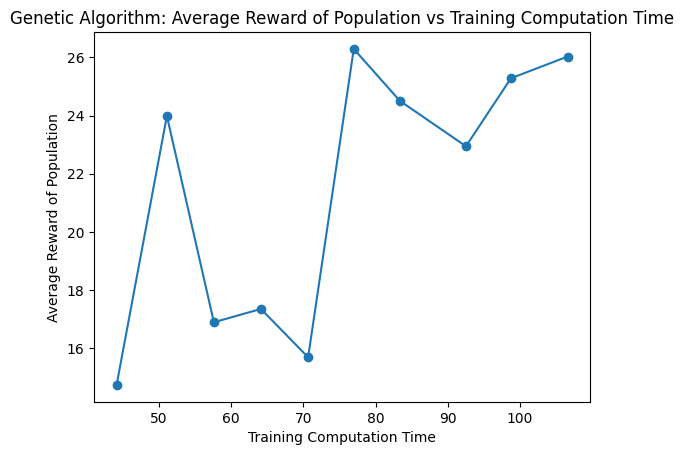

In [534]:
plt.plot(board.computation_times, board.reward_history)
plt.scatter(board.computation_times, board.reward_history)
# plt.vlines(x=board.computation_times, ymin=min(board.reward_history), ymax=max(board.reward_history), alpha=0.3, linestyles="dashed")
plt.xlabel("Training Computation Time")
plt.ylabel("Average Reward of Population")
plt.title("Genetic Algorithm: Average Reward of Population vs Training Computation Time")
plt.show()

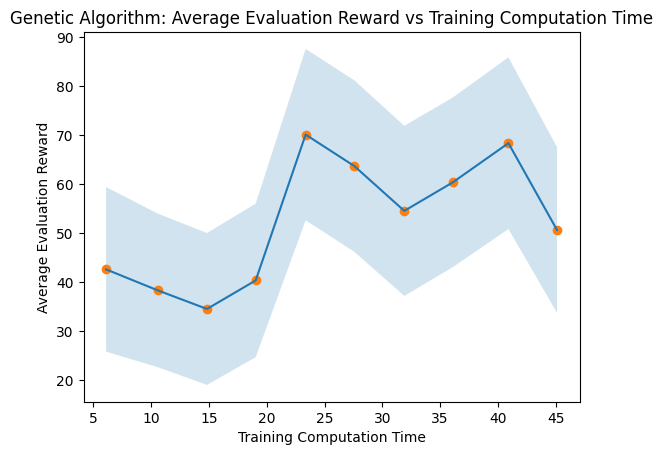

In [436]:
evaluation_mean_fitness = evaluation_fitness.mean(axis=1)
evaluation_std_fitness = evaluation_fitness.std(axis=1)
# plt.violinplot(evaluation_fitness.T, board.computation_times, showmeans=True, showmedians=True, showextrema=False)
plt.fill_between(board.computation_times, evaluation_mean_fitness - 0.1*evaluation_std_fitness, evaluation_mean_fitness + 0.1*evaluation_std_fitness, alpha=0.2)
plt.plot(board.computation_times, evaluation_mean_fitness)
plt.scatter(board.computation_times, evaluation_mean_fitness)
# plt.vlines(x=board.computation_times, ymin=min(evaluation_mean_fitness), ymax=max(evaluation_mean_fitness), alpha=0.3, linestyles="dashed")
plt.xlabel("Training Computation Time")
plt.ylabel("Average Evaluation Reward")
plt.title("Genetic Algorithm: Average Evaluation Reward vs Training Computation Time")
plt.show()

In [248]:
episode = board.run_episode(display)
probabilities, fitnesses = board.natural_selection(mutation_rate = 0.05)
best_dots = board.dots
eval_fitnesses = versatile_evaluate(best_dots, probabilities, display = True)

In [252]:
import seaborn as sns

Text(0.5, 1.0, 'Genetic Algorithm: Evaluation Fitness Density per Generation')

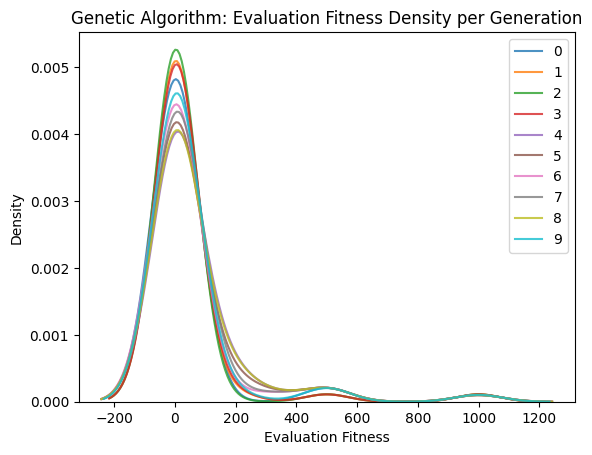

In [438]:
for i in range(10):
    sns.kdeplot(evaluation_fitness[i, :], label=i, alpha=0.8)
plt.legend()
plt.xlabel("Evaluation Fitness")
# plt.ylim((0, 0.008))
plt.title("Genetic Algorithm: Evaluation Fitness Density per Generation")

### GA: Try Different Seeds

In [192]:
seed_computation_times = []
seed_rewards = []
seed_eval_rewards = []
for i in tqdm(range(2)):
    board, evaluation_mean_fitness = run_genetic_algorithm(False, num_generations=5, seed=i)
    seed_computation_times.append(board.computation_times)
    seed_rewards.append(board.reward_history)
    seed_eval_rewards.append(evaluation_mean_fitness)

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\kathe\AppData\Local\Temp\ipykernel_32420\3527207854.py:3: DeprecationWarning: The depth argument is deprecated, and is ignored
  DISPLAYSURF = pygame.display.set_mode((0, 0), pygame.FULLSCREEN, pygame.RESIZABLE)
100%|██████████| 2/2 [00:55<00:00, 27.90s/it]


In [193]:
seed_computation_times = np.array(seed_computation_times)
seed_rewards = np.array(seed_rewards)
seed_eval_rewards = np.array(seed_eval_rewards)

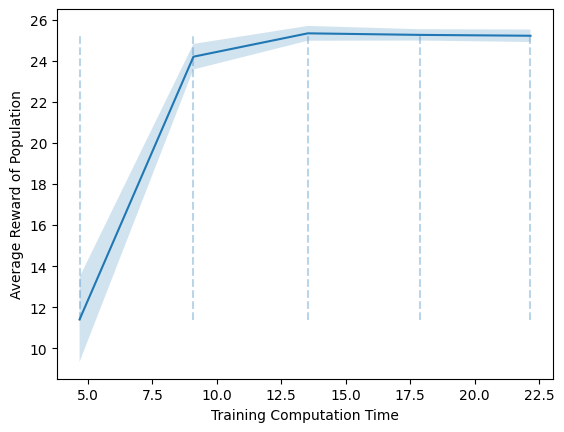

In [198]:
mean_seed_computation_times = seed_computation_times.mean(axis=0)
mean_seed_rewards = seed_rewards.mean(axis=0)
stdv_seed_rewards = seed_rewards.std(axis=0)

plt.fill_between(mean_seed_computation_times, mean_seed_rewards - 0.5*stdv_seed_rewards, mean_seed_rewards + 0.5*stdv_seed_rewards, alpha=0.2)
plt.plot(mean_seed_computation_times, mean_seed_rewards)
plt.vlines(x=mean_seed_computation_times, ymin=min(mean_seed_rewards), ymax=max(mean_seed_rewards), alpha=0.3, linestyles="dashed")
plt.xlabel("Training Computation Time")
plt.ylabel("Average Reward of Population")
plt.show()

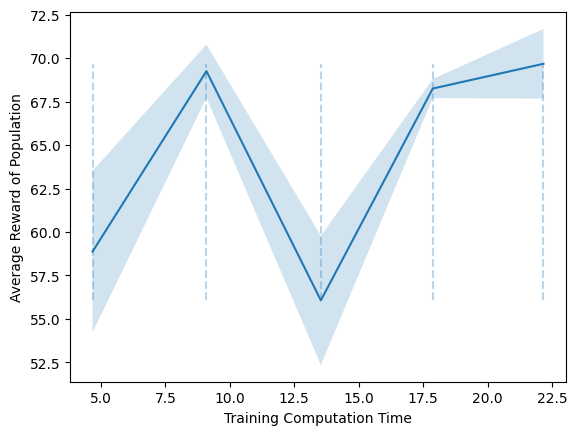

In [201]:
mean_eval_seed_rewards = seed_eval_rewards.mean(axis=0)
stdv_eval_seed_rewards = seed_eval_rewards.std(axis=0)

plt.fill_between(mean_seed_computation_times, mean_eval_seed_rewards - 0.5*stdv_eval_seed_rewards, mean_eval_seed_rewards + 0.5*stdv_eval_seed_rewards, alpha=0.2)
plt.plot(mean_seed_computation_times, mean_eval_seed_rewards)
plt.vlines(x=mean_seed_computation_times, ymin=min(mean_eval_seed_rewards), ymax=max(mean_eval_seed_rewards), alpha=0.3, linestyles="dashed")
plt.xlabel("Training Computation Time")
plt.ylabel("Average Reward of Population")
plt.show()

In [163]:
# for i in range(5):
#     computation_times = seed_computation_times[i]
#     rewards = seed_rewards[i]
#     plt.plot(computation_times, rewards)
#     plt.vlines(x=computation_times, ymin=min(rewards), ymax=max(rewards), alpha=0.3, linestyles="dashed")
#     plt.xlabel("Training Computation Time")
#     plt.ylabel("Average Reward of Population")

In [107]:
episode = board.run_episode(display=True)
probabilities, fitnesses = board.natural_selection(mutation_rate = 0.05)

best_dots = board.dots
eval_fitnesses = evaluate(best_dots, probabilities, display = True)
eval_fitnesses.mean()

66.88886604795198

### How does population size affect mean reward?

In [355]:
population_sizes = [50, 100, 150, 200, 250]
population_boards = []
evaluation_means_list = []
for i in tqdm(population_sizes):
    t1 = time.time()
    board, evaluation_means = run_genetic_algorithm(False, num_generations=10, initialization_size=200, gen_size=i, seed=30)
    t2 = time.time()
    population_boards.append(board)
    evaluation_means_list.append(evaluation_means)
    # fitness_df = pd.DataFrame({"computation_time": board.computation_times, "mean_fitness": board.reward_history, "eval_mean_fitness": evaluation_means, "population_size": i, "mutation_rate":0.05, "seed":30})
    # initialization_dfs.append(fitness_df)

# initialization_df = pd.concat(initialization_dfs)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\kathe\AppData\Local\Temp\ipykernel_32420\2052025817.py:3: DeprecationWarning: The depth argument is deprecated, and is ignored
  DISPLAYSURF = pygame.display.set_mode((0, 0), pygame.FULLSCREEN, pygame.RESIZABLE)
100%|██████████| 5/5 [03:55<00:00, 47.19s/it]


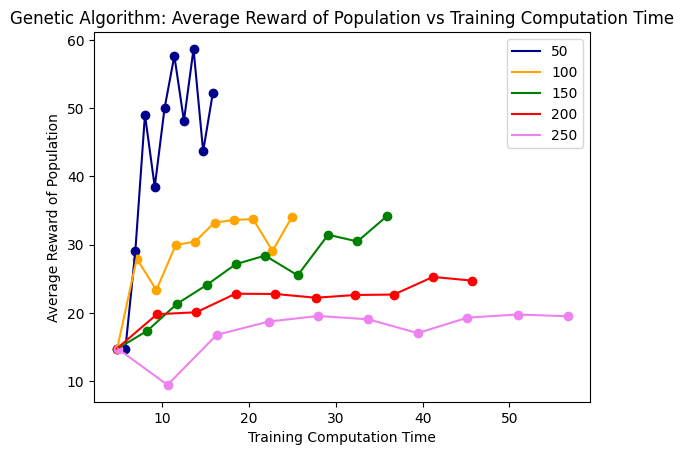

In [505]:
colors = ["darkblue", "orange", "green", "red", "violet"]
plot_population_rewards(population_boards, population_sizes, "Genetic Algorithm: Average Reward of Population vs Training Computation Time")

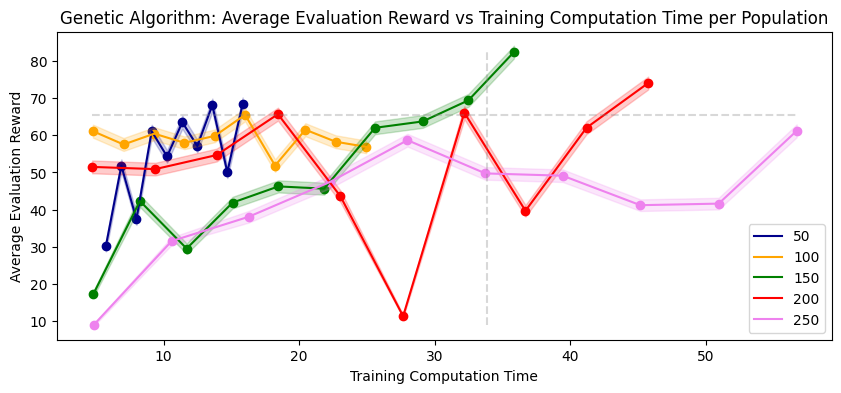

In [549]:
title = "Genetic Algorithm: Average Evaluation Reward vs Training Computation Time per Population"
plot_reward(population_boards, evaluation_means_list, population_sizes, title)

In [459]:
get_num_ga_policies(population_boards)

[6, 5, 8, 28, 22]

Text(0.5, 1.0, 'Genetic Algorithm: Evaluation Fitness Density on 10th Generation per Population Size')

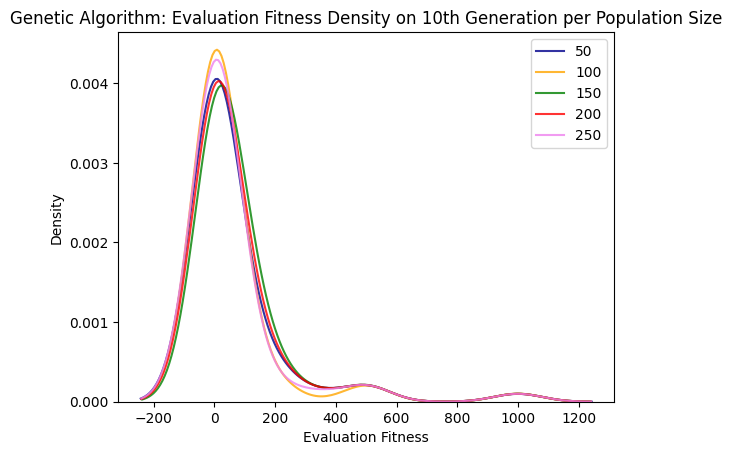

In [378]:
for i in range(len(evaluation_means_list)):
    evaluation_fitness = evaluation_means_list[i]
    sns.kdeplot(evaluation_fitness[9, :], label=population_sizes[i], alpha=0.8, color=colors[i])

plt.legend()
plt.xlabel("Evaluation Fitness")
# plt.ylim((0, 0.008))
plt.title("Genetic Algorithm: Evaluation Fitness Density on 10th Generation per Population Size")

### GA: How does mutation rate affect reward?

In [383]:
mutation_rates = [0.01, 0.05, 0.1, 0.2, 0.5]
mutation_boards = []
mutation_evaluation_list = []
for i in tqdm(mutation_rates):
    t1 = time.time()
    board, evaluations = run_genetic_algorithm(False, num_generations=10, gen_size=150, mutation_rate=i)
    t2 = time.time()
    mutation_boards.append(board)
    mutation_evaluation_list.append(evaluations)


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\kathe\AppData\Local\Temp\ipykernel_32420\2052025817.py:3: DeprecationWarning: The depth argument is deprecated, and is ignored
  DISPLAYSURF = pygame.display.set_mode((0, 0), pygame.FULLSCREEN, pygame.RESIZABLE)
100%|██████████| 5/5 [04:06<00:00, 49.28s/it]


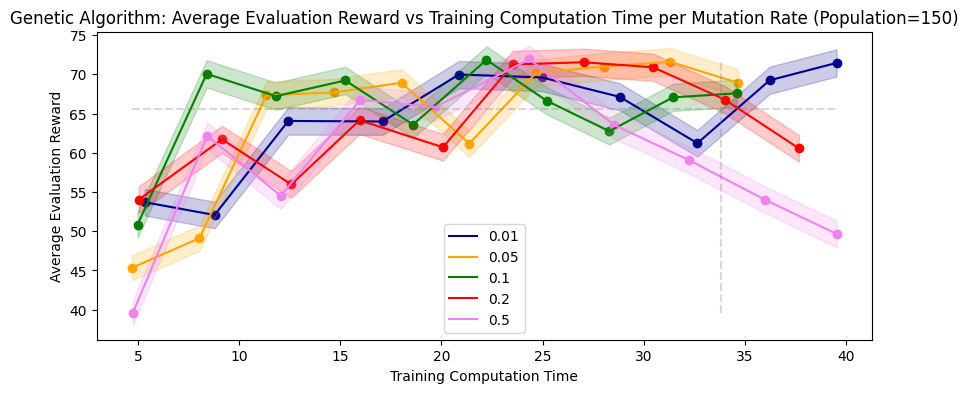

In [461]:
title = "Genetic Algorithm: Average Evaluation Reward vs Training Computation Time per Mutation Rate (Population=150)"
plot_reward(mutation_boards, mutation_evaluation_list, mutation_rates, title)

In [457]:
get_num_ga_policies(mutation_boards)

[3, 10, 22, 46, 91]

#### GA: How does scale factor affect reward?

In [442]:
scale_factors = [1, 1.5, 2, 2.5, 3]
scale_factor_boards = []
scale_factor_evaluation_list = []
for i in tqdm(scale_factors):
    t1 = time.time()
    board, evaluations = run_genetic_algorithm(False, num_generations=10, gen_size=150, scale_factor=i)
    t2 = time.time()
    scale_factor_boards.append(board)
    scale_factor_evaluation_list.append(evaluations)

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\kathe\AppData\Local\Temp\ipykernel_32420\435046507.py:5: DeprecationWarning: The depth argument is deprecated, and is ignored
  DISPLAYSURF = pygame.display.set_mode((0, 0), pygame.FULLSCREEN, pygame.RESIZABLE)
100%|██████████| 4/4 [03:22<00:00, 50.65s/it]


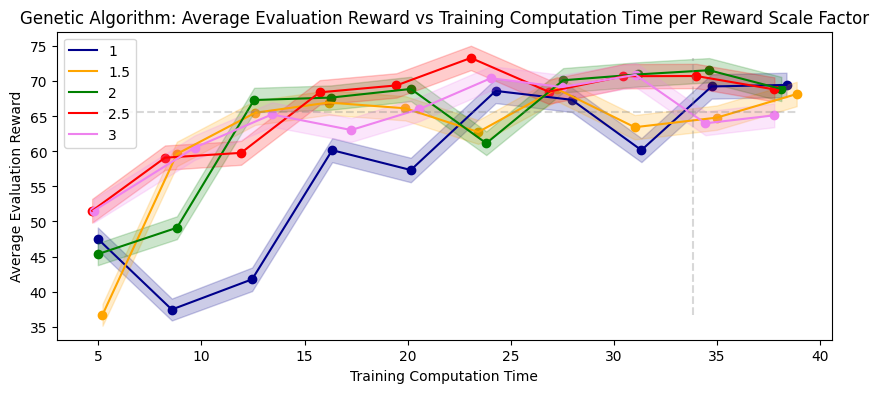

In [462]:
title = "Genetic Algorithm: Average Evaluation Reward vs Training Computation Time per Reward Scale Factor"
plot_reward(scale_factor_boards, scale_factor_evaluation_list, scale_factors, title)

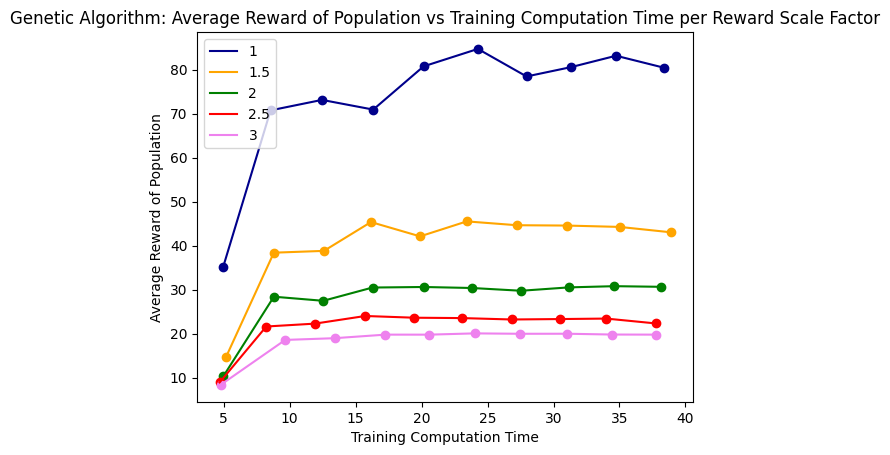

In [508]:
plot_population_rewards(scale_factor_boards, scale_factors, "Genetic Algorithm: Average Reward of Population vs Training Computation Time per Reward Scale Factor")

### REINFORCE (reward-to-go)

In [17]:
seed = 4152024

def run_reinforce(seed, display=False, scale_factor=2):
    batch_size = 1
    set_seed(seed)

    pygame.init()
    survival_areas =  [SurvivalArea(0, 0, 15, 15)]
    board = Board(70, 8, survival_areas, scale_factor=scale_factor)

    # Initialize 200 random creatures. Chose to optimize creature whose reward improved the most
    board.populate(200, device="cpu")
    episode = board.run_episode(display=True, seed=seed)
    best_dot = board.get_most_improved()
    board.populate(1)
    board.spawn_loc = [60, 60]

    # Switch to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_dot.brain = best_dot.brain.to(device)
    best_dot.brain.device = device

    dot_colors = []
    for dot in board.dots:
        dot.brain = best_dot.brain
        dot.color = best_dot.color
        dot_colors.append(dot.color)
    board.dot_colors = dot_colors

    board.reset()
    episode = board.run_episode(seed=seed, display=True)
    return board

In [39]:
seed = 30
batch_size = 1

re_board = run_reinforce(seed, scale_factor=2)
re_board.train(300, display=False, seed=seed, batch_size=batch_size)
# torch.save(board.dots[0].brain.state_dict(), "best_brain_575.pt")

 37%|███▋      | 110/300 [00:27<00:46,  4.05it/s]


KeyboardInterrupt: 

In [141]:
# seed = 30
# batch_size = 1
# board = run_reinforce(seed)

# t1 = time.time()
# eval_fitness_means = []
# computation_times = []
# for i in range(6):
#     board.train(50, display=False, seed=seed, batch_size=batch_size)
#     # eval_fitnesses = versatile_evaluate(board.dots, num_dots=50, display = False)
#     # eval_fitness_means.append(eval_fitnesses.mean())
#     # computation_times.append((time.time() - t1))


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


In [35]:
best_dots = re_board.dots
for _ in range(10):
    eval_fitnesses = versatile_evaluate(best_dots, num_dots=50, display = True)
eval_fitnesses.mean()

63.72663605109304

In [238]:
torch.save(board.dots[0].brain.state_dict(), f"best_brain_{seed}_{batch_size}.pt")

Text(0.5, 1.0, 'REINFORCE (reward-to-go): Training Reward for Seed=30')

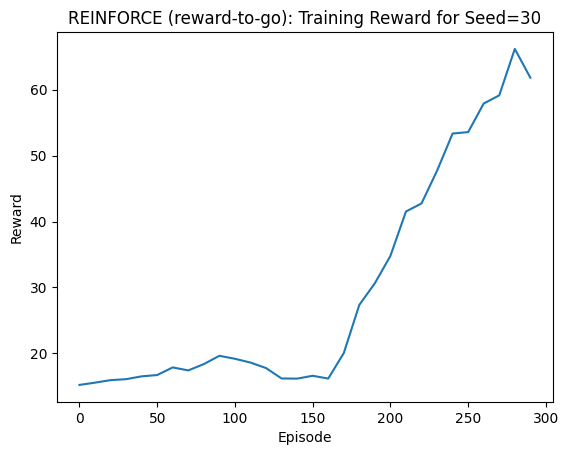

In [221]:
plt.figure(figsize=(6,3))
plt.plot(10*np.array(range(len(board.reward_history))), board.reward_history)
plt.ylabel("Reward")
plt.xlabel("Episode")
plt.title(f"REINFORCE (reward-to-go): Training Reward for Seed={seed}")

Text(0.5, 1.0, 'REINFORCE (reward-to-go): Training Reward for Seed=30')

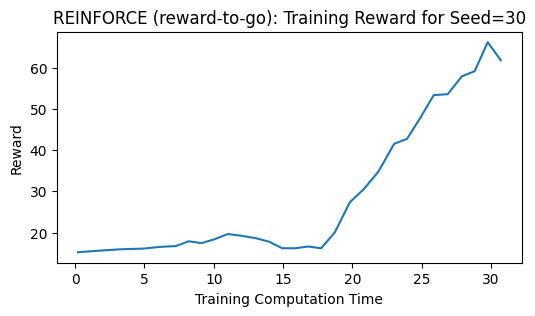

In [548]:
plt.figure(figsize=(6,3))
plt.plot(board.computation_times, board.reward_history)
plt.ylabel("Reward")
plt.xlabel("Training Computation Time")
plt.title(f"REINFORCE (reward-to-go): Training Reward for Seed={seed}")

In [241]:
board.computation_times[-1]

33.82592821121216

#### REINFORCE: How does scale factor affect reward?

In [517]:
seed = 30
batch_size = 1
scale_factors = [1, 1.5, 2, 2.5, 3]


reinforce_computation_times = []
reinforce_boards = []
reinforce_evals = []
reinforce_eval_stds = []

for i in tqdm(scale_factors):

    board = run_reinforce(seed, scale_factor=i)
    board.train(300, display=False, seed=seed, batch_size=batch_size)
    reinforce_computation_times.append(board.computation_times[-1])

    best_dots = board.dots
    eval_fitnesses = versatile_evaluate(best_dots, num_dots=50, display = False)

    reinforce_evals.append(eval_fitnesses.mean())
    reinforce_eval_stds.append(eval_fitnesses.std())

    reinforce_boards.append(board)

100%|██████████| 5/5 [06:53<00:00, 82.69s/it]


In [520]:
board = reinforce_boards[3]
best_dots = board.dots
eval_fitnesses = versatile_evaluate(best_dots, num_dots=50, display = True)

KeyboardInterrupt: 

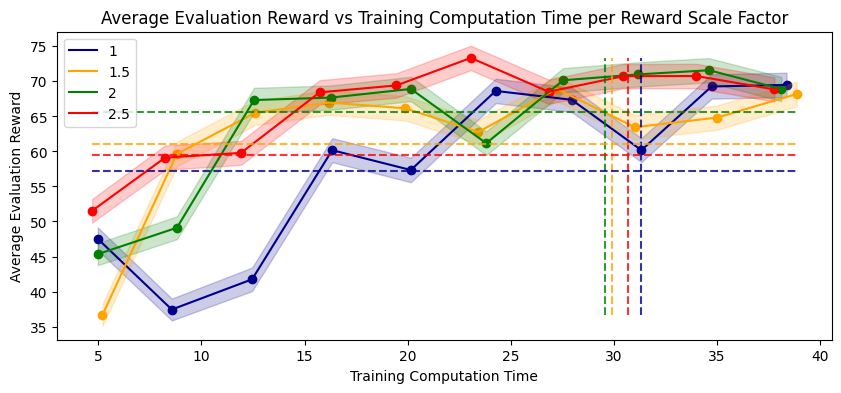

In [481]:
boards = scale_factor_boards
evaluation_list = scale_factor_evaluation_list
labels = scale_factors
title = "Average Evaluation Reward vs Training Computation Time per Reward Scale Factor"

plt.figure(figsize=(10, 4))

min_eval = 9999
max_eval = -9999
min_time = 999
max_time = 0

for i in range(len(evaluation_list[:-1])):
    evaluation_fitness = evaluation_list[i]
    board = boards[i]

    evaluation_mean_fitness = evaluation_fitness.mean(axis=1)
    evaluation_std_fitness = evaluation_fitness.std(axis=1)
    comp_times = np.array(board.computation_times)
    
    plt.fill_between(comp_times, evaluation_mean_fitness - 0.01*evaluation_std_fitness, evaluation_mean_fitness + 0.01*evaluation_std_fitness, alpha=0.2, color=colors[i])
    plt.plot(comp_times, evaluation_mean_fitness, color=colors[i], label = labels[i])
    plt.scatter(comp_times, evaluation_mean_fitness, color=colors[i])

    if evaluation_mean_fitness.min() < min_eval:
        min_eval = evaluation_mean_fitness.min()
    if evaluation_mean_fitness.max() > max_eval:
        max_eval = evaluation_mean_fitness.max()
    if comp_times.min() < min_time:
        min_time = comp_times.min()
    if comp_times.max() > max_time:
        max_time = comp_times.max()
    
plt.vlines(x=reinforce_computation_times[:-1], ymin=min_eval, ymax=max_eval, linestyle="--", alpha=0.8, color=colors)
plt.hlines(y=reinforce_evals[:-1], xmin=min_time, xmax=max_time, linestyle="--", alpha=0.8, color=colors)
plt.xlabel("Training Computation Time")
plt.ylabel("Average Evaluation Reward")
plt.title(title)
plt.legend()
plt.show()


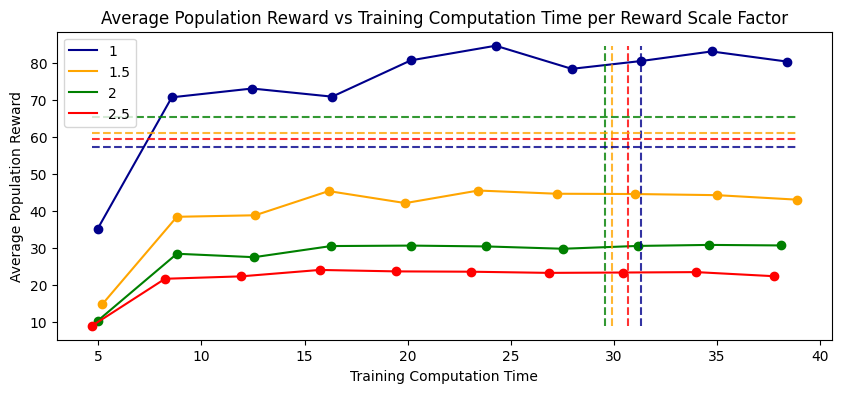

In [511]:
boards = scale_factor_boards
evaluation_list = scale_factor_evaluation_list
labels = scale_factors
title = "Average Population Reward vs Training Computation Time per Reward Scale Factor"

plt.figure(figsize=(10, 4))

min_eval = 9999
max_eval = -9999
min_time = 999
max_time = 0

for i in range(len(evaluation_list[:-1])):
    evaluation_fitness = evaluation_list[i]
    board = boards[i]

    comp_times = np.array(board.computation_times)
    val = np.array(board.reward_history)
    
    plt.plot(comp_times, val, color=colors[i], label = labels[i])
    plt.scatter(comp_times, val, color=colors[i])

    if val.min() < min_eval:
        min_eval = val.min()
    if val.max() > max_eval:
        max_eval = val.max()
    if comp_times.min() < min_time:
        min_time = comp_times.min()
    if comp_times.max() > max_time:
        max_time = comp_times.max()
    
plt.vlines(x=reinforce_computation_times[:-1], ymin=min_eval, ymax=max_eval, linestyle="--", alpha=0.8, color=colors)
plt.hlines(y=reinforce_evals[:-1], xmin=min_time, xmax=max_time, linestyle="--", alpha=0.8, color=colors)
plt.xlabel("Training Computation Time")
plt.ylabel("Average Population Reward")
plt.title(title)
plt.legend()
plt.show()


In [491]:
sc_np = np.array(scale_factor_evaluation_list)

In [489]:
best_dots = board.dots
eval_fitnesses = versatile_evaluate(best_dots, num_dots=50, display = True)
eval_fitnesses.mean()

60.848496855845006

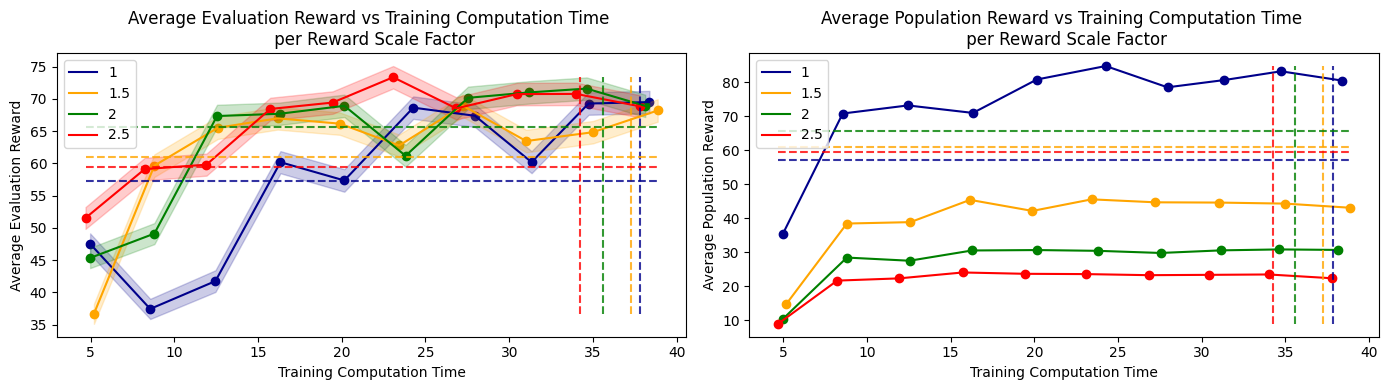

In [524]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# First subplot
axs[0].set_title("Average Evaluation Reward vs Training Computation Time \n per Reward Scale Factor")
min_eval = 9999
max_eval = -9999
min_time = 999
max_time = 0

for i in range(len(evaluation_list[:-1])):
    evaluation_fitness = evaluation_list[i]
    board = boards[i]

    evaluation_mean_fitness = evaluation_fitness.mean(axis=1)
    evaluation_std_fitness = evaluation_fitness.std(axis=1)
    comp_times = np.array(board.computation_times)
    
    axs[0].fill_between(comp_times, evaluation_mean_fitness - 0.01*evaluation_std_fitness, evaluation_mean_fitness + 0.01*evaluation_std_fitness, alpha=0.2, color=colors[i])
    axs[0].plot(comp_times, evaluation_mean_fitness, color=colors[i], label = labels[i])
    axs[0].scatter(comp_times, evaluation_mean_fitness, color=colors[i])

    if evaluation_mean_fitness.min() < min_eval:
        min_eval = evaluation_mean_fitness.min()
    if evaluation_mean_fitness.max() > max_eval:
        max_eval = evaluation_mean_fitness.max()
    if comp_times.min() < min_time:
        min_time = comp_times.min()
    if comp_times.max() > max_time:
        max_time = comp_times.max()

axs[0].vlines(x=reinforce_computation_times[:-1], ymin=min_eval, ymax=max_eval, linestyle="--", alpha=0.8, color=colors)
axs[0].hlines(y=reinforce_evals[:-1], xmin=min_time, xmax=max_time, linestyle="--", alpha=0.8, color=colors)
axs[0].set_xlabel("Training Computation Time")
axs[0].set_ylabel("Average Evaluation Reward")
axs[0].legend()

# Second subplot
axs[1].set_title("Average Population Reward vs Training Computation Time \n per Reward Scale Factor")
min_eval = 9999
max_eval = -9999
min_time = 999
max_time = 0

for i in range(len(evaluation_list[:-1])):
    evaluation_fitness = evaluation_list[i]
    board = boards[i]

    comp_times = np.array(board.computation_times)
    val = np.array(board.reward_history)
    
    axs[1].plot(comp_times, val, color=colors[i], label = labels[i])
    axs[1].scatter(comp_times, val, color=colors[i])

    if val.min() < min_eval:
        min_eval = val.min()
    if val.max() > max_eval:
        max_eval = val.max()
    if comp_times.min() < min_time:
        min_time = comp_times.min()
    if comp_times.max() > max_time:
        max_time = comp_times.max()

axs[1].vlines(x=reinforce_computation_times[:-1], ymin=min_eval, ymax=max_eval, linestyle="--", alpha=0.8, color=colors)
axs[1].hlines(y=reinforce_evals[:-1], xmin=min_time, xmax=max_time, linestyle="--", alpha=0.8, color=colors)
axs[1].set_xlabel("Training Computation Time")
axs[1].set_ylabel("Average Population Reward")
axs[1].legend()

plt.tight_layout()
plt.show()


### Save Instances of REINFORCE (reward-to-go) for Multiple Seeds

In [210]:
import pandas as pd

In [212]:
temp_df = pd.DataFrame({"eval_episode": range(len(board.reward_history)), "reward_history":board.reward_history, "seed": seed, "batch_size":batch_size, "time": board.training_time})
temp_df.to_csv("rl_training_5.csv", index=False)

In [213]:
def save_run(board, seed, file_name="rl_training_5.csv", batch_size=1):
    temp_df = pd.DataFrame({"eval_episode": range(len(board.reward_history)), "reward_history":board.reward_history, "seed": seed, "batch_size":batch_size, "time": board.training_time})
    all_df = pd.read_csv(file_name)
    all_df = pd.concat([all_df, temp_df])
    all_df.to_csv(file_name, index=False)

save_run(board, seed)
    

In [214]:
mean_eval_fitnesses = []
for i in tqdm(range(10)):
    seed = i
    board = run_reinforce(seed)
    board.train(300, display=False, seed=seed, batch_size=1)
    eval_fitness = versatile_evaluate(best_dots, num_dots=50, display = True)
    mean_eval_fitnesses.append(eval_fitness.mean())
    
    save_run(board, seed)

# all_df = pd.read_csv("rl_training_4.csv")

100%|██████████| 10/10 [16:35<00:00, 99.56s/it] 


In [498]:
all_df = pd.read_csv("rl_training_5.csv")

In [502]:
all_df = all_df.loc[all_df["seed"] != 30]

Text(0.5, 1.0, 'Reward for Seed=30 per Seed')

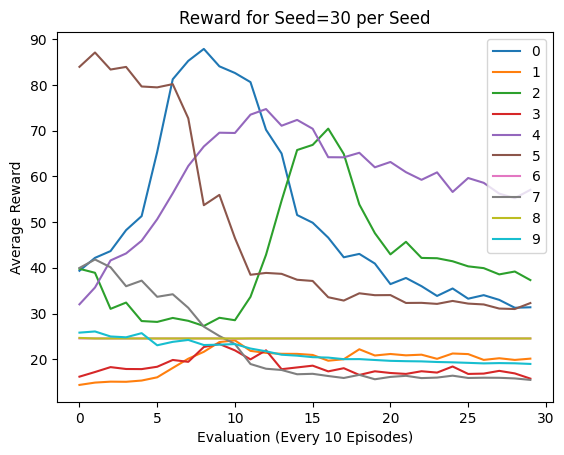

In [503]:
seeds = all_df["seed"].unique()
for s in seeds:
    subset = all_df.loc[all_df["batch_size"] == 1]
    subset = subset.loc[subset["seed"] == s]
    plt.plot(subset["eval_episode"], subset["reward_history"])

plt.legend(labels = seeds)
plt.ylabel("Average Reward")
plt.xlabel("Evaluation (Every 10 Episodes)")
plt.title(f"Reward for Seed={seed} per Seed")

Text(0.5, 1.0, 'Reward for Seed=412024 per batch_size')

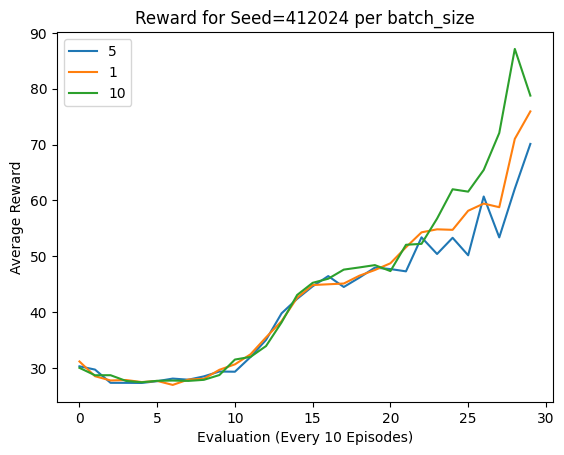

In [254]:

batch_sizes = all_df["batch_size"].unique()
for b in batch_sizes:
    subset = all_df.loc[all_df["batch_size"] == b]
    plt.plot(subset["eval_episode"], subset["reward_history"])

plt.legend(labels = batch_sizes)
plt.ylabel("Average Reward")
plt.xlabel("Evaluation (Every 10 Episodes)")
plt.title(f"Reward for Seed={seed} per batch_size")

### Multiple Survival Areas